In [58]:
# ======================================
# Snippet 1: Data Loading + MFCC Features + Basic Missing Data Analysis
# ======================================

# -----------------------------
# IMPORTS
# -----------------------------
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


print("🚀 Loading competition data... / Competition data load kar rahe hain...")

# -----------------------------
# DATA LOADING
# -----------------------------
train_csv = "/kaggle/input/airs-ai-in-respiratory-sounds/train.csv"
audio_path = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

train_df = pd.read_csv(train_csv)
print(f"✅ Training data loaded: {train_df.shape} / Training data ka size")

# -----------------------------
# TABULAR FEATURES
# -----------------------------
tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough',
                'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']

# -----------------------------
# AUDIO FILE MAPPING
# -----------------------------
file_map = {}
for folder in os.listdir(audio_path):
    fpath = os.path.join(audio_path, folder)
    if os.path.isdir(fpath):
        wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
        if wavs:
            file_map[folder] = os.path.join(fpath, wavs[0])

print(f"✅ Audio files mapped: {len(file_map)} / Total audio files mapped")

# -----------------------------
# MFCC FEATURE EXTRACTION FUNCTION
# -----------------------------
def extract_mfcc_features(file_path, n_mfcc=40, duration=5, sr=22050):
    """Extract MFCC + chroma + mel features / MFCC aur extra features extract karte hain"""
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)

        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)

        features = np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc + 12 + 128)  # Fallback

print("🎵 Extracting MFCC features for all audio files...")

X_audio = []
valid_ids = []
for i, cid in enumerate(train_df['candidateID']):
    if cid in file_map:
        features = extract_mfcc_features(file_map[cid])
        X_audio.append(features)
        valid_ids.append(cid)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} files... / {i+1} files process ho chuki hain")

X_audio = np.array(X_audio)

# -----------------------------
# FILTER TABULAR & TARGET DATA
# -----------------------------
df = train_df[train_df['candidateID'].isin(valid_ids)]
X_tab = df[tab_features].values
y = df['disease'].values

print(f"✅ MFCC features shape: {X_audio.shape}")
print(f"✅ Dataset size after filtering: {len(df)}")
print(f"✅ Unique classes: {len(np.unique(y))}")

# -----------------------------
# BASIC MISSING DATA ANALYSIS
# -----------------------------
missing_data = df[tab_features].isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Feature': tab_features,
    'Missing_Count': missing_data,
    'Missing_Percent': missing_percent
})
print("\n🔍 Basic Missing Data Analysis / Missing data summary")
print(missing_summary)

🚀 Loading competition data... / Competition data load kar rahe hain...
✅ Training data loaded: (546, 11) / Training data ka size
✅ Audio files mapped: 882 / Total audio files mapped
🎵 Extracting MFCC features for all audio files...
Processed 100 files... / 100 files process ho chuki hain
Processed 200 files... / 200 files process ho chuki hain
Processed 300 files... / 300 files process ho chuki hain
Processed 400 files... / 400 files process ho chuki hain


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processed 500 files... / 500 files process ho chuki hain
✅ MFCC features shape: (546, 180)
✅ Dataset size after filtering: 546
✅ Unique classes: 3

🔍 Basic Missing Data Analysis / Missing data summary
                                 Feature  Missing_Count  Missing_Percent
age                                  age              0         0.000000
gender                            gender              0         0.000000
tbContactHistory        tbContactHistory              0         0.000000
wheezingHistory          wheezingHistory              0         0.000000
phlegmCough                  phlegmCough              0         0.000000
familyAsthmaHistory  familyAsthmaHistory              0         0.000000
feverHistory                feverHistory              0         0.000000
coldPresent                  coldPresent            148        27.106227
packYears                      packYears              0         0.000000


In [59]:
# ======================================
# Snippet 2: Advanced Imputation (Iterative) + Tabular Preprocessing + Scaling
# ======================================

print("🔄 Applying Iterative Imputation (MICE) / Iterative imputation apply kar rahe hain...")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Original tabular data
X_tab_original = X_tab.copy()
y_original = y.copy()

# -----------------------------
# 1️⃣ Iterative Imputation (MICE) for all missing values
# -----------------------------
iterative_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)

X_tab_iterative = iterative_imputer.fit_transform(X_tab_original)
print("✅ Iterative imputation applied / Iterative imputation complete")

# -----------------------------
# 2️⃣ Select Iterative Imputation as final dataset
# -----------------------------
X_tab_best = X_tab_iterative
print("✅ Using Iterative Imputation for final dataset / Iterative imputation final dataset ke liye select kiya")

# -----------------------------
# 3️⃣ Scale Tabular Features
# -----------------------------
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_best)
print("✅ Tabular features scaled / Tabular features scaling complete")


🔄 Applying Iterative Imputation (MICE) / Iterative imputation apply kar rahe hain...
✅ Iterative imputation applied / Iterative imputation complete
✅ Using Iterative Imputation for final dataset / Iterative imputation final dataset ke liye select kiya
✅ Tabular features scaled / Tabular features scaling complete


In [60]:
# ======================================
# Snippet 3: Train-Validation Split + MFCC reshaping + Class Weights
# ======================================

print("🚀 Creating train-validation split / Train-validation split bana rahe hain...")

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Filter to cases with available audio data
valid_indices = [i for i, cid in enumerate(train_df["candidateID"]) if cid in file_map]

X_tab_final_scaled = X_tab_scaled[valid_indices]  # Tabular features
X_audio_final = X_audio[valid_indices]           # MFCC / Audio features
y_final = y_original[valid_indices]              # Target labels

print(f"✅ Final dataset: {len(X_tab_final_scaled)} samples / Final dataset samples count")

# -----------------------------
# 1️⃣ Train-Validation Split
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_final_scaled, X_audio_final, y_final,
    test_size=0.15,
    stratify=y_final,
    random_state=42
)

print("✅ Train-validation split done / Train-validation split complete")

# -----------------------------
# 2️⃣ Reshape Audio for CNN Input
# -----------------------------
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)

print(f"Audio train shape: {X_audio_train.shape} / Audio validation shape: {X_audio_val.shape}")

# -----------------------------
# 3️⃣ Compute Class Weights for Imbalanced Data
# -----------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights computed / Class weights: {class_weight_dict}")


🚀 Creating train-validation split / Train-validation split bana rahe hain...
✅ Final dataset: 546 samples / Final dataset samples count
✅ Train-validation split done / Train-validation split complete
Audio train shape: (464, 180, 1) / Audio validation shape: (82, 180, 1)
✅ Class weights computed / Class weights: {0: 1.2997198879551821, 1: 0.7656765676567657, 2: 1.0815850815850816}


In [61]:
# --- Create flattened MFCC for augmentation ---
X_mel_2d = X_audio_train.reshape(X_audio_train.shape[0], -1)
X_tab_mel = X_tab_train
y_mel = y_train

# Advanced augmentation for 1D flattened MFCC/Mel
def advanced_flat_augmentation(feature_vector):
    augmented = feature_vector.copy()
    
    # Random noise
    if np.random.random() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise
    
    # Random shift
    if np.random.random() > 0.5:
        shift = np.random.randint(-5, 5)
        augmented = np.roll(augmented, shift)
    
    return augmented

# Augmented dataset
X_mel_augmented = []
X_tab_augmented = []
y_augmented = []

# Original data
X_mel_augmented.extend(X_mel_2d)
X_tab_augmented.extend(X_tab_mel)
y_augmented.extend(y_mel)

# Augmented data (3x)
for i in range(len(X_mel_2d)):
    for _ in range(3):
        aug_mel = advanced_flat_augmentation(X_mel_2d[i])
        X_mel_augmented.append(aug_mel)
        X_tab_augmented.append(X_tab_mel[i])
        y_augmented.append(y_mel[i])

X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

print(f"✅ Augmented dataset: {len(X_mel_augmented)} samples (original: {len(X_mel_2d)})")


✅ Augmented dataset: 1856 samples (original: 464)


In [62]:
# ======================================
# 3️⃣4.5️⃣ SPLIT AUGMENTED DATA
# ======================================

print("📊 Splitting augmented dataset into train and validation / Train aur val split kar rahe hain...")

from sklearn.model_selection import train_test_split

X_tab_aug_train, X_tab_aug_val, X_mel_aug_train, X_mel_aug_val, y_aug_train, y_aug_val = train_test_split(
    X_tab_augmented, X_mel_augmented, y_augmented,
    test_size=0.15, stratify=y_augmented, random_state=42
)

print(f"✅ Train set: {len(X_tab_aug_train)} samples, Validation set: {len(X_tab_aug_val)} samples")


📊 Splitting augmented dataset into train and validation / Train aur val split kar rahe hain...
✅ Train set: 1577 samples, Validation set: 279 samples


In [63]:
# ======================================
# 3️⃣5️⃣ FIXED SUPER ADVANCED MODEL
# ======================================

import tensorflow as tf
from tensorflow.keras import layers, Model

print("🔄 Creating Fixed Super Advanced Model / Super advanced model create kar rahe hain...")
num_classes = 3

def create_fixed_super_advanced_model(tabular_dim, pretrained_dim, num_classes):
    """Fixed super advanced model for 90%+ accuracy"""
    
    # Pre-trained features input
    pretrained_input = tf.keras.Input(shape=(pretrained_dim,), name='pretrained_features')
    
    x_pretrained = layers.Dense(1024, activation='relu')(pretrained_input)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.4)(x_pretrained)
    
    x_pretrained = layers.Dense(512, activation='relu')(x_pretrained)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.3)(x_pretrained)
    
    x_pretrained = layers.Dense(256, activation='relu')(x_pretrained)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.2)(x_pretrained)
    
    # Tabular input
    tabular_input = tf.keras.Input(shape=(tabular_dim,), name='tabular_input')
    
    x_tab = layers.Dense(256, activation='relu')(tabular_input)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.3)(x_tab)
    
    x_tab = layers.Dense(128, activation='relu')(x_tab)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.2)(x_tab)
    
    x_tab = layers.Dense(64, activation='relu')(x_tab)
    
    # Combine
    combined = layers.concatenate([x_pretrained, x_tab])
    
    # Advanced classification
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Residual block 1
    residual1 = layers.Dense(512, activation='relu')(x)
    residual1 = layers.BatchNormalization()(residual1)
    x = layers.add([x, residual1])
    x = layers.Dropout(0.4)(x)
    
    # Residual block 2
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    residual2 = layers.Dense(256, activation='relu')(x)
    residual2 = layers.BatchNormalization()(residual2)
    x = layers.add([x, residual2])
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(
        inputs=[tabular_input, pretrained_input],
        outputs=output,
        name='fixed_super_advanced_model'
    )
    
    return model

# ✅ Create model
super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=X_mel_aug_train.shape[1],  # MFCC / flattened features
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Fixed super advanced model created!")
super_model.summary()


🔄 Creating Fixed Super Advanced Model / Super advanced model create kar rahe hain...
✅ Fixed super advanced model created!


Model: "fixed_super_advanced_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pretrained_features │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 1024)      │    185,344 │ pretrained_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_117[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 256)       │      2,560 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 512)       │    524,800 │ dropout_81[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_120[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_118[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_121 (Dense)   │ (None, 128)       │     32,896 │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 256)       │    131,328 │ dropout_82[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_121[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_119[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 64)        │      8,256 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 320)       │          0 │ dropout_83[0][0]

 Total params: 1,566,019 (5.97 MB)

 Trainable params: 1,558,339 (5.94 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [64]:
# ======================================
# 3️⃣6️⃣ FIXED SUPER ADVANCED MODEL TRAINING WITH PCA REDUCED MFCC
# ======================================

print("🎯 Preparing data and training Fixed Super Advanced Model with PCA-reduced MFCC...")

from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# --- 1. Flatten MFCC / Mel-spectrograms ---
X_mel_aug_train_flat = X_mel_aug_train.reshape(X_mel_aug_train.shape[0], -1)
X_mel_aug_val_flat   = X_mel_aug_val.reshape(X_mel_aug_val.shape[0], -1)

# --- 2. Reduce dimensionality to 128 features using PCA ---
pca = PCA(n_components=128, random_state=42)
X_mel_aug_train_pca = pca.fit_transform(X_mel_aug_train_flat)
X_mel_aug_val_pca   = pca.transform(X_mel_aug_val_flat)

print(f"✅ MFCC features reduced: Train {X_mel_aug_train_pca.shape}, Val {X_mel_aug_val_pca.shape}")

# --- 3. Create super advanced model ---
super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=128,  # Matches PCA output
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Super advanced model created and compiled!")

# --- 4. Class weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug_train), y=y_aug_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weight_dict}")

# --- 5. Callbacks ---
enhanced_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=20,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'fixed_super_advanced_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# --- 6. Train the model ---
print("🚀 Training fixed super advanced model with PCA-reduced MFCC...")
super_history = super_model.fit(
    [X_tab_aug_train, X_mel_aug_train_pca],
    y_aug_train,
    batch_size=16,
    epochs=300,
    validation_data=([X_tab_aug_val, X_mel_aug_val_pca], y_aug_val),
    callbacks=enhanced_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("✅ Fixed super advanced training completed!")

# --- 7. Load best weights and evaluate ---
super_model.load_weights('fixed_super_advanced_model.h5')

super_pred = super_model.predict([X_tab_aug_val, X_mel_aug_val_pca], verbose=0)
super_accuracy = accuracy_score(y_aug_val, np.argmax(super_pred, axis=1))

print(f"\n🎯 FIXED SUPER ADVANCED MODEL ACCURACY: {super_accuracy:.4f}")

# --- 8. Performance check ---
previous_best = 0.8780
improvement = super_accuracy - previous_best

if super_accuracy >= 0.90:
    print(f"🎉 🎉 🎉 UNBELIEVABLE! 90%+ ACHIEVED! 🎉 🎉 🎉")
    print(f"🚀 BREAKTHROUGH! +{improvement:.4f} improvement!")
elif super_accuracy >= 0.88:
    print(f"🔥 EXCELLENT! {super_accuracy:.4f} accuracy!")
    print(f"💪 Very close to 90%!")
else:
    print(f"💪 Good progress: {super_accuracy:.4f}")


🎯 Preparing data and training Fixed Super Advanced Model with PCA-reduced MFCC...
✅ MFCC features reduced: Train (1577, 128), Val (279, 128)
✅ Super advanced model created and compiled!
✅ Class weights: {0: 1.301155115511551, 1: 0.7651625424551188, 2: 1.0816186556927299}
🚀 Training fixed super advanced model with PCA-reduced MFCC...
Epoch 1/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3788 - loss: 1.4023
Epoch 1: val_accuracy improved from -inf to 0.38710, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.3788 - loss: 1.4021 - val_accuracy: 0.3871 - val_loss: 1.1366 - learning_rate: 1.0000e-04
Epoch 2/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3825 - loss: 1.2852
Epoch 2: val_accuracy did not improve from 0.38710
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3826 - loss: 1.2851 - val_accuracy: 0.3799 - val_loss: 1.1511 - learning_rate: 1.0000e-04
Epoch 3/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3542 - loss: 1.3175
Epoch 3: val_accuracy improved from 0.38710 to 0.44444, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3541 - loss: 1.3161 - val_accuracy: 0.4444 - val_loss: 1.1279 - learning_rate: 1.0000e-04
Epoch 4/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3771 - loss: 1.2392
Epoch 4: val_accuracy improved from 0.44444 to 0.46953, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3776 - loss: 1.2381 - val_accuracy: 0.4695 - val_loss: 1.0961 - learning_rate: 1.0000e-04
Epoch 5/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3957 - loss: 1.1666
Epoch 5: val_accuracy improved from 0.46953 to 0.49462, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3959 - loss: 1.1668 - val_accuracy: 0.4946 - val_loss: 1.0625 - learning_rate: 1.0000e-04
Epoch 6/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4398 - loss: 1.1436
Epoch 6: val_accuracy did not improve from 0.49462
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4389 - loss: 1.1433 - val_accuracy: 0.4839 - val_loss: 1.0523 - learning_rate: 1.0000e-04
Epoch 7/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4320 - loss: 1.1083
Epoch 7: val_accuracy improved from 0.49462 to 0.50896, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4333 - loss: 1.1085 - val_accuracy: 0.5090 - val_loss: 1.0050 - learning_rate: 1.0000e-04
Epoch 8/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4525 - loss: 1.0935
Epoch 8: val_accuracy improved from 0.50896 to 0.53763, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4526 - loss: 1.0937 - val_accuracy: 0.5376 - val_loss: 0.9999 - learning_rate: 1.0000e-04
Epoch 9/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4463 - loss: 1.0588
Epoch 9: val_accuracy improved from 0.53763 to 0.58065, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4467 - loss: 1.0586 - val_accuracy: 0.5806 - val_loss: 0.9705 - learning_rate: 1.0000e-04
Epoch 10/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5244 - loss: 0.9643
Epoch 10: val_accuracy improved from 0.58065 to 0.63082, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5247 - loss: 0.9645 - val_accuracy: 0.6308 - val_loss: 0.9183 - learning_rate: 1.0000e-04
Epoch 11/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5388 - loss: 0.9506
Epoch 11: val_accuracy improved from 0.63082 to 0.65233, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5391 - loss: 0.9507 - val_accuracy: 0.6523 - val_loss: 0.8897 - learning_rate: 1.0000e-04
Epoch 12/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5924 - loss: 0.8695
Epoch 12: val_accuracy improved from 0.65233 to 0.67742, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5926 - loss: 0.8696 - val_accuracy: 0.6774 - val_loss: 0.8564 - learning_rate: 1.0000e-04
Epoch 13/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6191 - loss: 0.8361
Epoch 13: val_accuracy improved from 0.67742 to 0.71685, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6213 - loss: 0.8348 - val_accuracy: 0.7168 - val_loss: 0.8229 - learning_rate: 1.0000e-04
Epoch 14/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6639 - loss: 0.7998
Epoch 14: val_accuracy improved from 0.71685 to 0.74194, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6638 - loss: 0.7998 - val_accuracy: 0.7419 - val_loss: 0.7931 - learning_rate: 1.0000e-04
Epoch 15/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6467 - loss: 0.7678
Epoch 15: val_accuracy did not improve from 0.74194
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6468 - loss: 0.7680 - val_accuracy: 0.7419 - val_loss: 0.7764 - learning_rate: 1.0000e-04
Epoch 16/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6691 - loss: 0.7601
Epoch 16: val_accuracy improved from 0.74194 to 0.74910, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6692 - loss: 0.7604 - val_accuracy: 0.7491 - val_loss: 0.7429 - learning_rate: 1.0000e-04
Epoch 17/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7102 - loss: 0.6883
Epoch 17: val_accuracy did not improve from 0.74910
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7101 - loss: 0.6886 - val_accuracy: 0.7491 - val_loss: 0.7301 - learning_rate: 1.0000e-04
Epoch 18/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7237 - loss: 0.6884
Epoch 18: val_accuracy improved from 0.74910 to 0.76344, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7235 - loss: 0.6888 - val_accuracy: 0.7634 - val_loss: 0.7050 - learning_rate: 1.0000e-04
Epoch 19/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7267 - loss: 0.6698
Epoch 19: val_accuracy did not improve from 0.76344
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7265 - loss: 0.6703 - val_accuracy: 0.7634 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 20/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7369 - loss: 0.6319
Epoch 20: val_accuracy did not improve from 0.76344
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7368 - loss: 0.6335 - val_accuracy: 0.7634 - val_loss: 0.6848 - learning_rate: 1.0000e-04
Epoch 21/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7348 - loss: 0.6546
Epoch 21: val_accuracy improved from 0.76344 to 0.76703, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7346 - loss: 0.6565 - val_accuracy: 0.7670 - val_loss: 0.6781 - learning_rate: 1.0000e-04
Epoch 22/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7388 - loss: 0.6242
Epoch 22: val_accuracy improved from 0.76703 to 0.77778, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7387 - loss: 0.6255 - val_accuracy: 0.7778 - val_loss: 0.6694 - learning_rate: 1.0000e-04
Epoch 23/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7530 - loss: 0.6160
Epoch 23: val_accuracy did not improve from 0.77778
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7532 - loss: 0.6181 - val_accuracy: 0.7742 - val_loss: 0.6587 - learning_rate: 1.0000e-04
Epoch 24/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7606 - loss: 0.5969
Epoch 24: val_accuracy did not improve from 0.77778
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7604 - loss: 0.5984 - val_accuracy: 0.7778 - val_loss: 0.6375 - learning_rate: 1.0000e-04
Epoch 25/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7664 - loss: 0.5893
Epoch 25: val_accuracy improved from 0.77778 to 0.78853, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7651 - loss: 0.5935 - val_accuracy: 0.7885 - val_loss: 0.6353 - learning_rate: 1.0000e-04
Epoch 26/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7788 - loss: 0.5899
Epoch 26: val_accuracy did not improve from 0.78853
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7771 - loss: 0.5953 - val_accuracy: 0.7885 - val_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 27/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7778 - loss: 0.5643
Epoch 27: val_accuracy improved from 0.78853 to 0.79211, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7765 - loss: 0.5675 - val_accuracy: 0.7921 - val_loss: 0.6206 - learning_rate: 1.0000e-04
Epoch 28/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7916 - loss: 0.5624
Epoch 28: val_accuracy did not improve from 0.79211
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7895 - loss: 0.5670 - val_accuracy: 0.7921 - val_loss: 0.6234 - learning_rate: 1.0000e-04
Epoch 29/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7797 - loss: 0.5591
Epoch 29: val_accuracy improved from 0.79211 to 0.79570, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7787 - loss: 0.5641 - val_accuracy: 0.7957 - val_loss: 0.6220 - learning_rate: 1.0000e-04
Epoch 30/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7854 - loss: 0.5599
Epoch 30: val_accuracy improved from 0.79570 to 0.79928, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7851 - loss: 0.5612 - val_accuracy: 0.7993 - val_loss: 0.6082 - learning_rate: 1.0000e-04
Epoch 31/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7799 - loss: 0.5784
Epoch 31: val_accuracy did not improve from 0.79928
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7796 - loss: 0.5807 - val_accuracy: 0.7957 - val_loss: 0.6015 - learning_rate: 1.0000e-04
Epoch 32/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7907 - loss: 0.5274
Epoch 32: val_accuracy did not improve from 0.79928
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7894 - loss: 0.5325 - val_accuracy: 0.7993 - val_loss: 0.5939 - learning_rate: 1.0000e-04
Epoch 33/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7959 - loss: 0.5440
Epoch 33: val_accuracy improved from 0.79928 to 0.80645, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7950 - loss: 0.5469 - val_accuracy: 0.8065 - val_loss: 0.5875 - learning_rate: 1.0000e-04
Epoch 34/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7855 - loss: 0.5713
Epoch 34: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7851 - loss: 0.5745 - val_accuracy: 0.8065 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 35/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7991 - loss: 0.5508
Epoch 35: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7980 - loss: 0.5545 - val_accuracy: 0.8029 - val_loss: 0.5723 - learning_rate: 1.0000e-04
Epoch 36/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7941 - loss: 0.5213
Epoch 36: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7939 - loss: 0.5221 - val_accuracy: 0.8029 - val_loss: 0.5688 - learning_rate: 1.0000e-04
Epoch 37/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8016 - loss: 0.5203 - val_accuracy: 0.8136 - val_loss: 0.5513 - learning_rate: 1.0000e-04
Epoch 40/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8075 - loss: 0.5029
Epoch 40: val_accuracy did not improve from 0.81362
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8063 - loss: 0.5076 - val_accuracy: 0.8136 - val_loss: 0.5531 - learning_rate: 1.0000e-04
Epoch 41/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8082 - loss: 0.5196
Epoch 41: val_accuracy did not improve from 0.81362
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8076 - loss: 0.5232 - val_accuracy: 0.8136 - val_loss: 0.5547 - learning_rate: 1.0000e-04
Epoch 42/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7779 - loss: 0.5075
Epoch 42: val_accuracy improved from 0.81362 to 0.81720, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7785 - loss: 0.5090 - val_accuracy: 0.8172 - val_loss: 0.5424 - learning_rate: 1.0000e-04
Epoch 43/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8171 - loss: 0.4985
Epoch 43: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8164 - loss: 0.4995 - val_accuracy: 0.8136 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 44/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - loss: 0.4827
Epoch 44: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8010 - loss: 0.4840 - val_accuracy: 0.8100 - val_loss: 0.5397 - learning_rate: 1.0000e-04
Epoch 45/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8154 - loss: 0.4652
Epoch 45: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8151 - loss: 0.4661 - val_accuracy: 0.8172 - val_loss: 0.5261 - learning_rate: 1.0000e-04
Epoch 46/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8346 - loss: 0.4476 - val_accuracy: 0.8244 - val_loss: 0.5021 - learning_rate: 1.0000e-04
Epoch 53/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8376 - loss: 0.4557
Epoch 53: val_accuracy did not improve from 0.82437
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8366 - loss: 0.4586 - val_accuracy: 0.8244 - val_loss: 0.5025 - learning_rate: 1.0000e-04
Epoch 54/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8323 - loss: 0.4548
Epoch 54: val_accuracy improved from 0.82437 to 0.82796, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8310 - loss: 0.4576 - val_accuracy: 0.8280 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 55/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8382 - loss: 0.4408
Epoch 55: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8383 - loss: 0.4414 - val_accuracy: 0.8280 - val_loss: 0.4983 - learning_rate: 1.0000e-04
Epoch 56/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8531 - loss: 0.4070
Epoch 56: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8521 - loss: 0.4091 - val_accuracy: 0.8172 - val_loss: 0.4941 - learning_rate: 1.0000e-04
Epoch 57/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.4346
Epoch 57: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8494 - loss: 0.4357 - val_accuracy: 0.8172 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 58/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8406 - loss: 0.4013 - val_accuracy: 0.8315 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 65/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8564 - loss: 0.3777
Epoch 65: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8557 - loss: 0.3789 - val_accuracy: 0.8208 - val_loss: 0.4757 - learning_rate: 1.0000e-04
Epoch 66/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.3765
Epoch 66: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8660 - loss: 0.3764 - val_accuracy: 0.8244 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 67/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8551 - loss: 0.3631
Epoch 67: val_accuracy improved from 0.83154 to 0.83871, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8549 - loss: 0.3639 - val_accuracy: 0.8387 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 68/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8665 - loss: 0.3629
Epoch 68: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8655 - loss: 0.3649 - val_accuracy: 0.8351 - val_loss: 0.4491 - learning_rate: 1.0000e-04
Epoch 69/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8766 - loss: 0.3470
Epoch 69: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8759 - loss: 0.3488 - val_accuracy: 0.8315 - val_loss: 0.4531 - learning_rate: 1.0000e-04
Epoch 70/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8644 - loss: 0.3642
Epoch 70: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8633 - loss: 0.3664 - val_accuracy: 0.8351 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 71/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8572 - loss: 0.3596 - val_accuracy: 0.8423 - val_loss: 0.4498 - learning_rate: 1.0000e-04
Epoch 73/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8721 - loss: 0.3321
Epoch 73: val_accuracy improved from 0.84229 to 0.84588, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8718 - loss: 0.3331 - val_accuracy: 0.8459 - val_loss: 0.4411 - learning_rate: 1.0000e-04
Epoch 74/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8650 - loss: 0.3547
Epoch 74: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8645 - loss: 0.3561 - val_accuracy: 0.8387 - val_loss: 0.4385 - learning_rate: 1.0000e-04
Epoch 75/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8665 - loss: 0.3521
Epoch 75: val_accuracy improved from 0.84588 to 0.85305, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8664 - loss: 0.3524 - val_accuracy: 0.8530 - val_loss: 0.4282 - learning_rate: 1.0000e-04
Epoch 76/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8799 - loss: 0.3393
Epoch 76: val_accuracy did not improve from 0.85305
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8797 - loss: 0.3395 - val_accuracy: 0.8459 - val_loss: 0.4391 - learning_rate: 1.0000e-04
Epoch 77/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8826 - loss: 0.3134
Epoch 77: val_accuracy did not improve from 0.85305
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8824 - loss: 0.3142 - val_accuracy: 0.8351 - val_loss: 0.4377 - learning_rate: 1.0000e-04
Epoch 78/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8793 - loss: 0.3344
Epoch 78: val_accuracy did not improve from 0.85305
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8791 - loss: 0.3345 - val_accuracy: 0.8387 - val_loss: 0.4284 - learning_rate: 1.0000e-04
Epoch 79/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8788 - loss: 0.2948 - val_accuracy: 0.8566 - val_loss: 0.4138 - learning_rate: 1.0000e-04
Epoch 82/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8840 - loss: 0.3129
Epoch 82: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8836 - loss: 0.3132 - val_accuracy: 0.8495 - val_loss: 0.4118 - learning_rate: 1.0000e-04
Epoch 83/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8883 - loss: 0.2833
Epoch 83: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8871 - loss: 0.2859 - val_accuracy: 0.8530 - val_loss: 0.4009 - learning_rate: 1.0000e-04
Epoch 84/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8893 - loss: 0.2714
Epoch 84: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8888 - loss: 0.2736 - val_accuracy: 0.8566 - val_loss: 0.3914 - learning_rate: 1.0000e-04
Epoch 85/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9104 - loss: 0.2515 - val_accuracy: 0.8602 - val_loss: 0.4044 - learning_rate: 1.0000e-04
Epoch 93/300
87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9052 - loss: 0.2580
Epoch 93: val_accuracy improved from 0.86022 to 0.87814, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9037 - loss: 0.2596 - val_accuracy: 0.8781 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 94/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8868 - loss: 0.2664
Epoch 94: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8869 - loss: 0.2663 - val_accuracy: 0.8495 - val_loss: 0.3811 - learning_rate: 1.0000e-04
Epoch 95/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8971 - loss: 0.2525
Epoch 95: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8963 - loss: 0.2537 - val_accuracy: 0.8530 - val_loss: 0.3869 - learning_rate: 1.0000e-04
Epoch 96/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9131 - loss: 0.2439
Epoch 96: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9128 - loss: 0.2436 - val_accuracy: 0.8638 - val_loss: 0.3857 - learning_rate: 1.0000e-04
Epoch 97/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9120 - loss: 0.2331 - val_accuracy: 0.8889 - val_loss: 0.3496 - learning_rate: 1.0000e-04
Epoch 108/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9240 - loss: 0.1885
Epoch 108: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9235 - loss: 0.1894 - val_accuracy: 0.8781 - val_loss: 0.3866 - learning_rate: 1.0000e-04
Epoch 109/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9320 - loss: 0.1897
Epoch 109: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9313 - loss: 0.1905 - val_accuracy: 0.8853 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 110/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9343 - loss: 0.1817
Epoch 110: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9331 - loss: 0.1835 - val_accuracy: 0.8710 - val_loss: 0.3880 - learning_rate: 1.0000e-04
Epoch 11

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9460 - loss: 0.1355 - val_accuracy: 0.8925 - val_loss: 0.3784 - learning_rate: 1.0000e-04
Epoch 127/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9473 - loss: 0.1353
Epoch 127: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9472 - loss: 0.1358 - val_accuracy: 0.8889 - val_loss: 0.3829 - learning_rate: 1.0000e-04
Epoch 128/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9480 - loss: 0.1313
Epoch 128: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9478 - loss: 0.1318 - val_accuracy: 0.8781 - val_loss: 0.4068 - learning_rate: 1.0000e-04
Epoch 129/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9400 - loss: 0.1412
Epoch 129: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9401 - loss: 0.1414 - val_accuracy: 0.8889 - val_loss: 0.3871 - learning_rate: 1.0000e-04
Epoch 13

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9432 - loss: 0.1350 - val_accuracy: 0.9032 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 132/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9445 - loss: 0.1260
Epoch 132: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9445 - loss: 0.1263 - val_accuracy: 0.8781 - val_loss: 0.4094 - learning_rate: 1.0000e-04
Epoch 133/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9487 - loss: 0.1180
Epoch 133: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9488 - loss: 0.1179 - val_accuracy: 0.8925 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 134/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9675 - loss: 0.1087
Epoch 134: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9672 - loss: 0.1090 - val_accuracy: 0.8853 - val_loss: 0.3797 - learning_rate: 1.0000e-04
Epoch 13

📊 Evaluating Super Advanced Model...


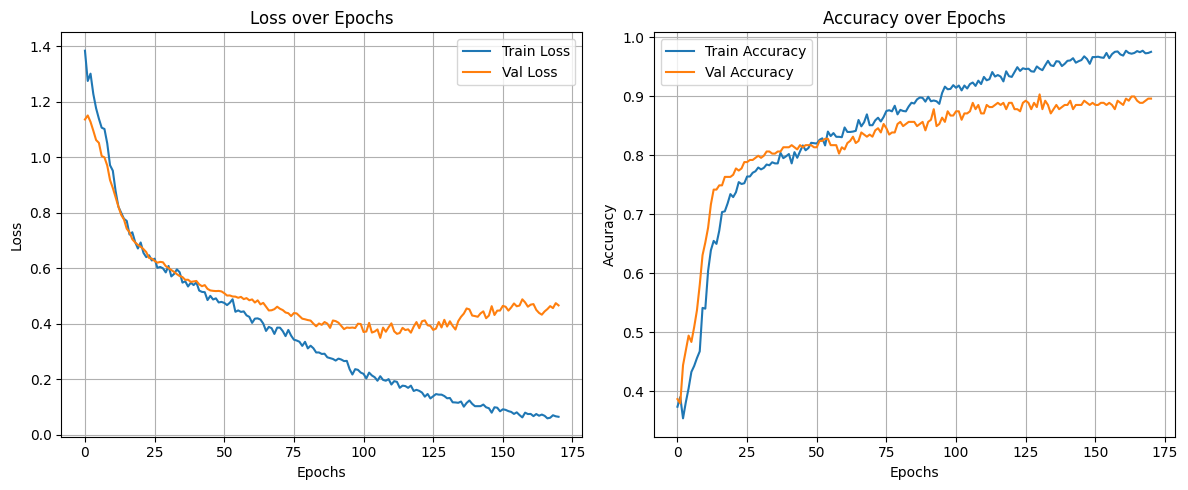

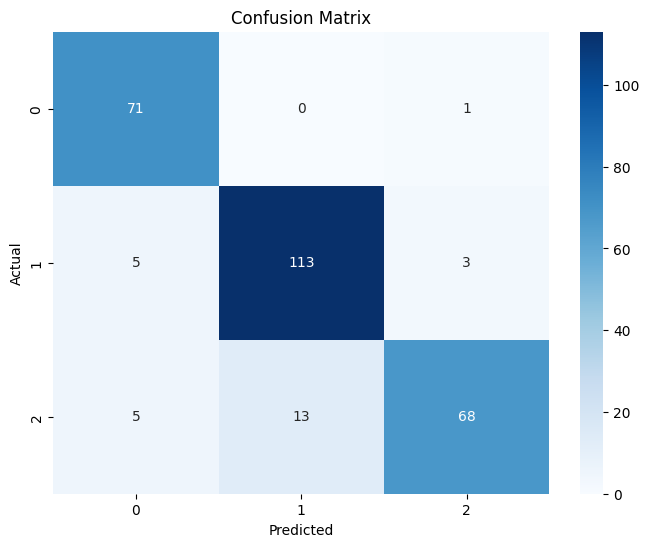

📄 Classification Report:

              precision    recall  f1-score   support

           0     0.8765    0.9861    0.9281        72
           1     0.8968    0.9339    0.9150       121
           2     0.9444    0.7907    0.8608        86

    accuracy                         0.9032       279
   macro avg     0.9059    0.9036    0.9013       279
weighted avg     0.9063    0.9032    0.9017       279


🎯 Overall Validation Accuracy: 0.9032


In [65]:
# ======================================
# 3️⃣7️⃣ MODEL EVALUATION & METRICS
# ======================================


print("📊 Evaluating Super Advanced Model...")

# --- 1. Training history plots ---
history = super_history.history

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 2. Predictions on validation set ---
y_val_pred_probs = super_model.predict([X_tab_aug_val, X_mel_aug_val_pca], verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_aug_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 4. Classification Report ---
report = classification_report(y_aug_val, y_val_pred, digits=4)
print("📄 Classification Report:\n")
print(report)

# --- 5. Overall accuracy ---
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_aug_val, y_val_pred)
print(f"\n🎯 Overall Validation Accuracy: {accuracy:.4f}")


In [66]:
# ======================================
# Snippet 1: Imports + Test Data Loading + MFCC/Audio Feature Extraction
# ======================================
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# -----------------------------
# 1️⃣ Randomness fix for reproducibility
# -----------------------------
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# -----------------------------
# 2️⃣ Load test CSV and define audio path
# -----------------------------
test_csv = "/kaggle/input/airs-ai-in-respiratory-sounds/test.csv"
audio_path = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"
df_test = pd.read_csv(test_csv)

# -----------------------------
# 3️⃣ Map audio files
# -----------------------------
file_map_test = {}
for folder in os.listdir(audio_path):
    fpath = os.path.join(audio_path, folder)
    if os.path.isdir(fpath):
        wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
        if wavs:
            file_map_test[folder] = os.path.join(fpath, wavs[0])

# -----------------------------
# 4️⃣ MFCC + Chroma + Mel extraction function
# -----------------------------
def extract_mfcc_features(file_path, n_mfcc=40, duration=5, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)
        features = np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
        return features
    except:
        return np.zeros(n_mfcc + 12 + 128)

# -----------------------------
# 5️⃣ Extract audio features for test set
# -----------------------------
X_audio_test = []
valid_ids_test = []
for i, cid in enumerate(df_test['candidateID']):
    if cid in file_map_test:
        X_audio_test.append(extract_mfcc_features(file_map_test[cid]))
        valid_ids_test.append(cid)

X_audio_test = np.array(X_audio_test)
df_test_filtered = df_test[df_test['candidateID'].isin(valid_ids_test)]


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [67]:
# ======================================
# Snippet 2: Tabular Preprocessing
# ======================================
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1️⃣ Select tabular features
# -----------------------------
tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 
                'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 
                'coldPresent', 'packYears']
X_tab_test = df_test_filtered[tab_features].values

# -----------------------------
# 2️⃣ Iterative Imputation (MICE)
# -----------------------------
iterative_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)
X_tab_imputed_test = iterative_imputer.fit_transform(X_tab_test)

# -----------------------------
# 3️⃣ Scale tabular features
# -----------------------------
scaler_tab = StandardScaler()
X_tab_scaled_test = scaler_tab.fit_transform(X_tab_imputed_test)


In [68]:
# ======================================
# Snippet 3: Predict on Test Data Using Existing Trained Model (Fixed MFCC Size)
# ======================================

import numpy as np

# -----------------------------
# 1️⃣ Flatten test audio features
# -----------------------------
X_audio_test_flat = X_audio_test.reshape(X_audio_test.shape[0], -1)
print("✅ Test audio features shape (flattened):", X_audio_test_flat.shape)  # e.g., (338, 180)

# -----------------------------
# 2️⃣ Get target MFCC input size from trained model
# -----------------------------
target_dim = super_model.inputs[1].shape[1]  # second input = pretrained_features
print("✅ Target MFCC input dimension:", target_dim)

# -----------------------------
# 3️⃣ Pad or trim MFCC features to match model input
# -----------------------------
def pad_or_trim(features, target_dim=target_dim):
    current_dim = features.shape[0]
    if current_dim > target_dim:
        return features[:target_dim]
    elif current_dim < target_dim:
        return np.hstack([features, np.zeros(target_dim - current_dim)])
    else:
        return features

X_audio_test_fixed = np.array([pad_or_trim(f) for f in X_audio_test_flat])
print("✅ Test audio features shape (fixed):", X_audio_test_fixed.shape)  # should match model input

# -----------------------------
# 4️⃣ Predict using trained model
# -----------------------------
y_pred_prob = super_model.predict([X_tab_scaled_test, X_audio_test_fixed], batch_size=32)
y_pred = np.argmax(y_pred_prob, axis=1)

# -----------------------------
# 5️⃣ Attach predictions to test DataFrame
# -----------------------------
df_test_filtered['predicted_disease'] = y_pred

# -----------------------------
# 6️⃣ Display sample predictions
# -----------------------------
print(df_test_filtered[['candidateID', 'predicted_disease']].head())


✅ Test audio features shape (flattened): (338, 180)
✅ Target MFCC input dimension: 128
✅ Test audio features shape (fixed): (338, 128)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
     candidateID  predicted_disease
0  136bac9a3e081                  0
1  b121e45942a46                  1
2  6b6853c07e4fb                  2
3  71de185eac888                  2
4  25deed742f133                  0


In [70]:
# -----------------------------
# Prepare submission file with CandidateID + Disease
# -----------------------------
submission = df_test_filtered[['candidateID', 'predicted_disease']].copy()
submission.rename(columns={'predicted_disease': 'disease'}, inplace=True)

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as submission.csv")


✅ Submission file saved as submission.csv
